## FGSM Attack

In [6]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

### Load in target model
This MobileNetV2, it was trained on ImageNet.

In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Prepare preprocess function and decode function

In [8]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector (1, 1000)
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

### Load in an image to see its prediction

(1, 1000)


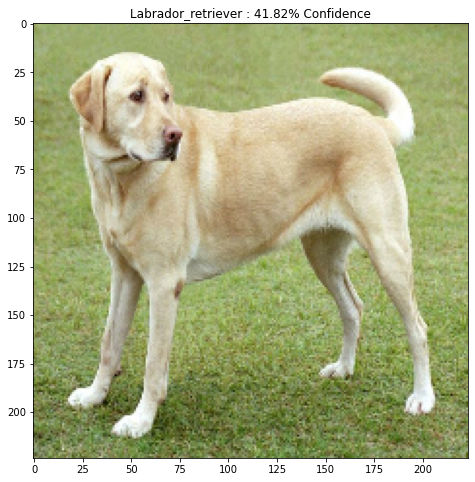

In [4]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)
print(image_probs.shape)

plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

### Build FGSM
FGSM takes one gradient step towards the destination. Because gradient step is too large, the real step is compressed.

shape of the label of labrador: (1, 1000)
shape of signed_grad:  (1, 224, 224, 3)
direction of first pixel:  tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)


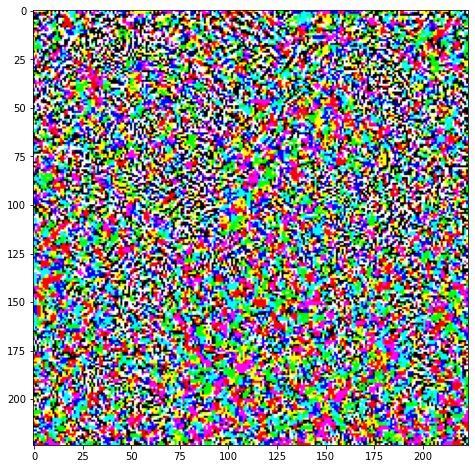

In [19]:
cate_ce = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = cate_ce(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    print('shape of signed_grad: ', signed_grad.shape)
    print('direction of first pixel: ', signed_grad[0][0][0])
    return signed_grad

# Get the input label of the image.
labrador_retriever_index = 208
NUM_CLASS = 1000
label = tf.one_hot(labrador_retriever_index, NUM_CLASS)
label = tf.reshape(label, (1, NUM_CLASS))
print('shape of the label of labrador:', label.shape)

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

### Add the perturbation to the original image

<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


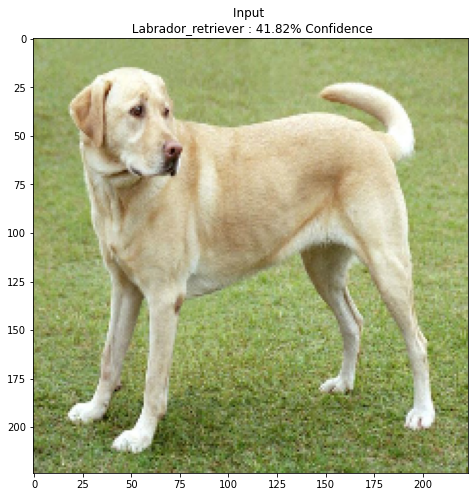

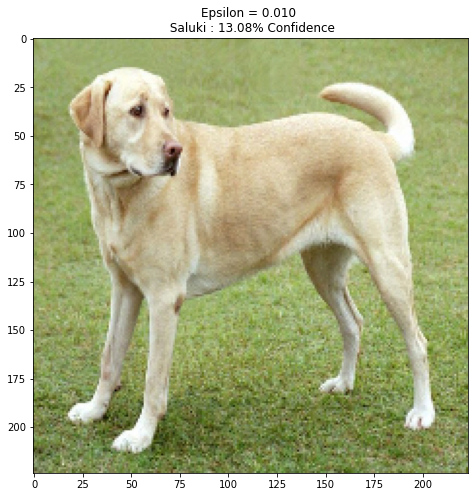

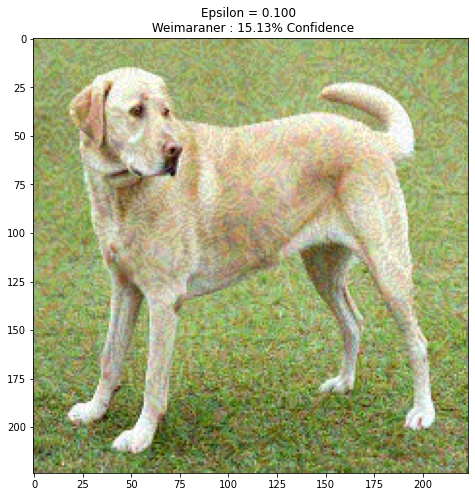

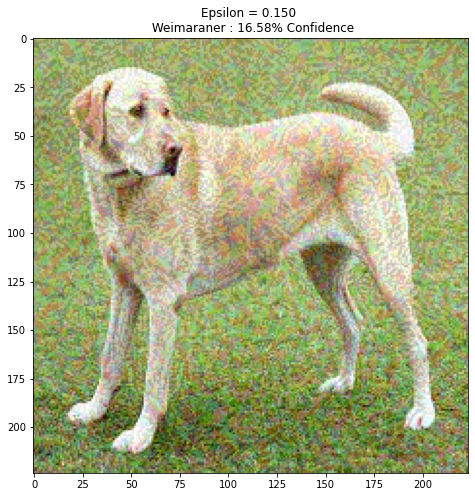

In [24]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
    plt.show()

ff = pretrained_model.predict(image)
print(type(ff))
cc = pretrained_model(image)
print(type(cc))

epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]
# ['Input', 'Epsilon = 0.01', 'Epsilon = 0.1', 'Epsilon = 0.15']

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    # compress the value of pixel to [-1, 1]
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])